In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error , r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [3]:
store_sales = pd.read_excel('/content/Sales Data.xlsx')
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Check for null values

In [4]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
store_sales = store_sales.drop(['store','item'],axis = 1)
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


Converting date to a month period and sum the items in each month

In [6]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales.head()

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


In [7]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


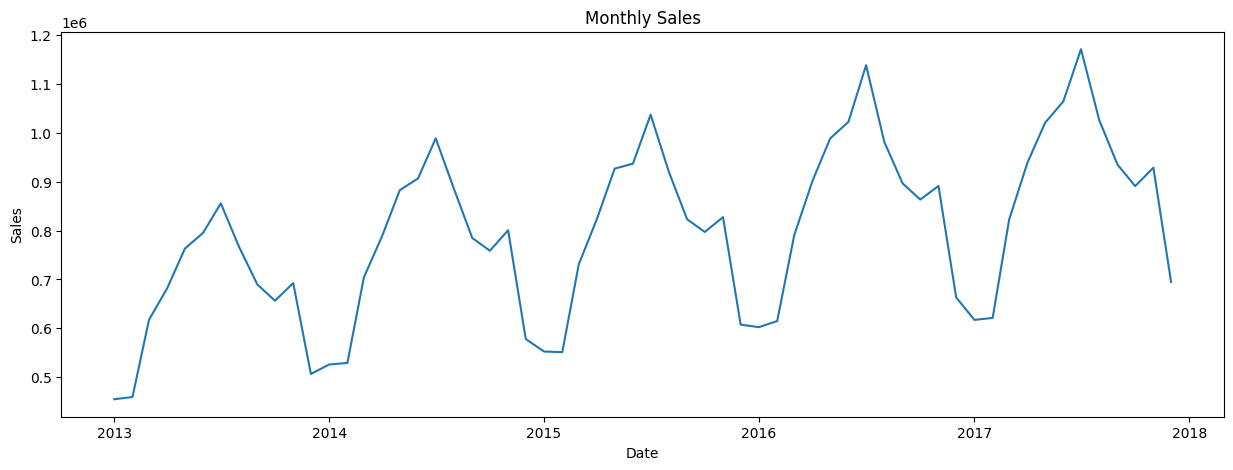

In [8]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [9]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [10]:
supervised_data = monthly_sales.drop(['date','sales'],axis = 1)

In [11]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [12]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [13]:
print('Train Data Shape :', train_data.shape)
print('Test Data Shape :', test_data.shape)

Train Data Shape : (35, 13)
Test Data Shape : (12, 13)


In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [15]:
X_train,y_train = train_data[:,1:],train_data[:,0:1]
X_test,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape: ',X_train.shape)
print('y_train Shape: ',y_train.shape)
print('X_test Shape: ',X_test.shape)
print('y_test Shape: ',y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


In [16]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [17]:
act_sales = monthly_sales['sales'][-13:].to_list()
print('Actual Sales: ',act_sales)

Actual Sales:  [663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)
lr_pred

array([ 0.0427074 ,  0.17284957,  1.09083796,  0.71220971,  0.58376708,
        0.33753568,  0.79053303, -0.71169155, -0.29772672, -0.01470231,
        0.24425358, -1.02944627])

In [19]:
lr_pred = lr_pred.reshape(-1,1)
#This is a set matrix - contains the input features of the test data , and also the predicted output
lr_pred_test_set = np.concatenate([lr_pred,X_test],axis = 1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [20]:
result_list = []
for index in range(0,len(lr_pred_test_set)):
    result_list.append(lr_pred_test_set[index][0] + act_sales[index])
lr_pred_series = pd.Series(result_list,name = 'Linear Prediction')
predict_df = predict_df.merge(lr_pred_series,left_index = True,right_index = True)

In [21]:
#print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])

print("Linear Regression MSE : ",lr_mse)
print("Linear Regression MAE : ",lr_mae)
print("Linear Regression R2 : ",lr_r2)

Linear Regression MSE :  16221.272385416869
Linear Regression MAE :  12433.184266490736
Linear Regression R2 :  0.9906152516380969


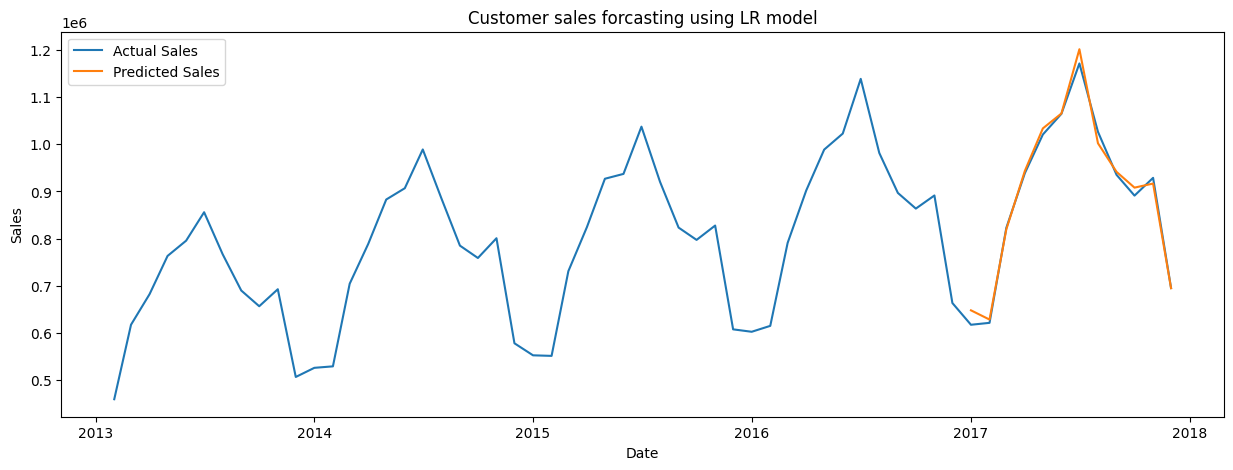

In [22]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#predicted sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.title("Customer sales forcasting using LR model")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()